In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [13]:
# Cell 3

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

BATCH_SIZE = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

# ImageDataGenerators for train/validation
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

# Training set
train_data_gen = train_image_generator.flow_from_directory(
    directory=train_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Validation set
val_data_gen = validation_image_generator.flow_from_directory(
    directory=validation_dir,
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary'
)

# Test set (⚠️ using image_dataset_from_directory since no subfolders)
test_data_gen = tf.keras.utils.image_dataset_from_directory(
    directory=test_dir,
    labels=None,                     # no labels for test set
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False
).map(lambda x: x/255.0)             # normalize


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 files.


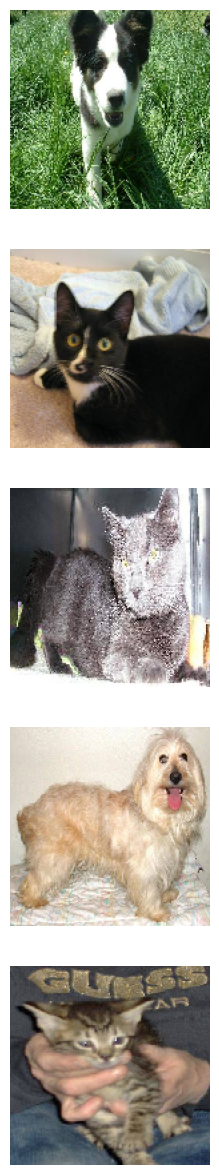

In [4]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [5]:
# 5

train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


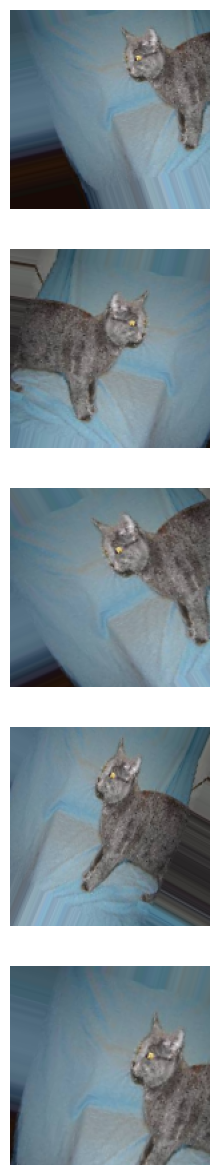

In [6]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [7]:
# 7

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary output: cat or dog
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
# 8

EPOCHS = 25

history = model.fit(
    train_data_gen,
    steps_per_epoch=len(train_data_gen),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=len(val_data_gen)
)


Epoch 1/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.6850 - loss: 0.5909 - val_accuracy: 0.6720 - val_loss: 0.5905
Epoch 2/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7332 - loss: 0.5537 - val_accuracy: 0.7300 - val_loss: 0.5463
Epoch 3/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.7690 - loss: 0.4948 - val_accuracy: 0.7310 - val_loss: 0.5364
Epoch 4/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8130 - loss: 0.4183 - val_accuracy: 0.7410 - val_loss: 0.5603
Epoch 5/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.8388 - loss: 0.3448 - val_accuracy: 0.7110 - val_loss: 0.6123
Epoch 6/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.8822 - loss: 0.2620 - val_accuracy: 0.7230 - val_loss: 0.6309
Epoch 7/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9206 - loss: 0.1945 - val_accuracy: 0.7510 - val_loss: 0.6896
Epoch 8/25
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.9496 - loss: 0.1339 - val_accuracy: 0.7520 - v

ValueError: x and y must have same first dimension, but have shapes (15,) and (25,)

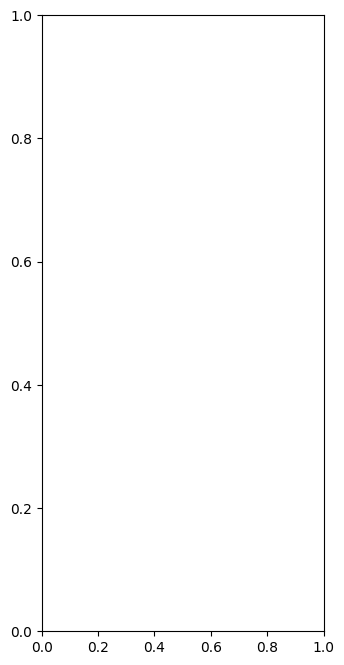

In [18]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step


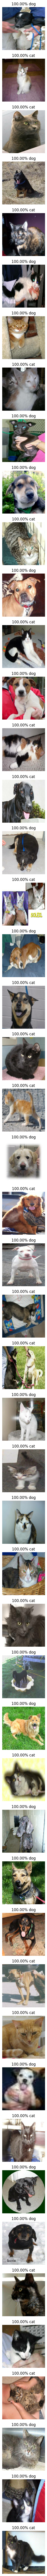

In [19]:
# Cell 10

# Predict probabilities
probabilities = model.predict(test_data_gen)

# Convert probabilities into 0 (cat) or 1 (dog)
probabilities = [int(round(p[0])) for p in probabilities]

# Convert dataset back to numpy images for plotting
test_images = []
for batch in test_data_gen.take(len(probabilities)//BATCH_SIZE + 1):
    test_images.extend(batch.numpy())

# Plot results
plotImages(test_images[:len(probabilities)], probabilities)


In [20]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 76.0% of the images of cats and dogs.
You passed the challenge!
